# Проект:  Исследовательский анализ данных  сервиса бронирования билетов и проверка гипотез  для Яндекс Афиша в Python 

- Автор: Буйневич Елена
- Дата: 04.12.2025

## Введение
Коллеги из продуктовой команды просят провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

## Цель проекта
Произвести анализ данных сервиса Яндекс Афиша для оценки динамики продажи/бронирования билетов на различные мероприятия за период с 1 июня по 31 октября 2024 года.

Данные содержатся в датасетах `final_tickets_orders_df.csv` и `final_tickets_events_df.csv`.  

Предстоит:
- ознакомление с данными и проверка их на корректность(полнота данных, дубликаты, пропуски, форматы, вбросы);
- исследовательский анализ данных;
- статистический анализ данных;
- вывод и рекомендации.

## Описание данных  
Датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой вы работали в предыдущих заданиях:  
- order_id — уникальный идентификатор заказа;  
- user_id — уникальный идентификатор пользователя;  
- created_dt_msk — дата создания заказа (московское время);  
- created_ts_msk — дата и время создания заказа (московское время);  
- event_id — идентификатор мероприятия из таблицы events;  
- cinema_circuit — сеть кинотеатров, если не применимо, то здесь будет значение 'нет';  
- age_limit — возрастное ограничение мероприятия;  
- currency_code — валюта оплаты, например rub для российских рублей;  
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных;  
- revenue — выручка от заказа;  
- service_name — название билетного оператора;  
- tickets_count — количество купленных билетов;  
- total — общая сумма заказа.  
В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет `final_tickets_events_df.csv` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Обратите внимание, что из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много. Датасет содержит такие поля:  
- event_id — уникальный идентификатор мероприятия;   
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных;  
- event_type_description — описание типа мероприятия;  
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее;  
- organizers — организаторы мероприятия;  
- region_name — название региона;  
- city_name — название города;  
- venue_id — уникальный идентификатор площадки;  
- venue_name — название площадки;  
- venue_address — адрес площадки;  

Датасет `final_tickets_tenge_df.csv` содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.   
Датасет содержит такие поля:  
- nominal — номинал (100 тенге);  
- data — дата;  
- curs — курс тенге к рублю;  
- cdx — обозначение валюты (kzt).  
Эти данные будут использованны для конвертации валюты.  

## Содержимое проекта

<font color='#777778'> </font>

1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию.
3. Исследовательский анализ данных.
4. Статистический анализ данных.
5. Общий вывод и рекомендации.

 ### 1. Загрузка данных и знакомство с ними

In [1]:
pip install matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем библиотеки pandas, seaborn, matplotlib, scipy, statsmodels.stats, matplotlib_venn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from scipy import stats as st
from scipy.stats import mannwhitneyu

In [3]:
# Создаём датафрем с данными из /datasets/final_tickets_orders_df.csv, выводим первые 5 строк на экран
final_tickets_orders_df = pd.read_csv('/datasets/final_tickets_orders_df.csv')

# Выводим информацию о датафрейме
final_tickets_orders_df.info()
final_tickets_orders_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Подсчитываем долю пропусков
ch = final_tickets_orders_df['days_since_prev'].isna().sum() / len(final_tickets_orders_df['days_since_prev'])

# Выводим результат (в процентах или долях)
print(f'Пропуски в столбце days_since_prev составили: {ch:.2%}')  

Пропуски в столбце days_since_prev составили: 7.54%


Данные датасета `final_tickets_orders_df.csv` соответствуют заявленным в описании.
Датасет содержит `14 столбцов` и `290849 строки`, из них:
- строковые данные (object) - 7 столбцов, 
- числовые значения целочисленные значения без дробной части (int64) - 4 столбца,
- числовой тип данных с плавающей точкой (float64) - 3 столбца.  
Столбец days_since_prev содержит 21940 пропусков - 7,54% (Если покупки не было, то данные содержат пропуск).

Нужно произвести форматирование для столбцов:
- created_dt_msk и created_ts_msk к формату даты,
- так же можно уменьшить разрядность для столбцов age_limit, event_id, order_id, revenue, tickets_count, total 

По столбцу days_since_prev форматирование проводить нельзя, т.к. данные будут участвовать в тесте Манна-Уитни

In [5]:
# Создаём датафрем с данными из /datasets/final_tickets_events_df.csv, выводим первые 5 строк на экран
final_tickets_events_df = pd.read_csv('/datasets/final_tickets_events_df.csv')

# Выводим информацию о датафрейме
final_tickets_events_df.info()

final_tickets_events_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


Данные датасета `final_tickets_events_df.csv` соответствуют заявленным в описании. Датасет содержит `11 столбцов` и `22427 строк`, из них:

- строковые данные (object) - 8 столбцов,  
- числовые значения целочисленные значения без дробной части (int64) - 3 столбца.  

Данные не имеют пропусков.
Нужно уменьшить разрядность для столбцов - event_id, city_id и venue_id.

In [6]:
# Создаём датафрем с данными из /datasets/final_tickets_tenge_df.csv, выводим первые 5 строк на экран
final_tickets_tenge_df = pd.read_csv('/datasets/final_tickets_tenge_df.csv')

# Выводим информацию о датафрейме
final_tickets_tenge_df.info()
final_tickets_tenge_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Данные датасета `final_tickets_tenge_df.csv` соответствуют заявленным в описании. Датасет содержит `4 столбца` и `357 строк`, из них:

- строковые данные (object) - 2 столбца,  
- числовые значения целочисленные значения без дробной части (int64) - 1 столбец,  
- числовой тип данных с плавающей точкой (float64) - 1 столбец. 

Данные не имеют пропусков.
Нужно произвести форматирование для столбца data привести к формату даты.
Нужно уменьшить разрядность для столбца nominal.

## 2. Предобработка данных и подготовка их к исследованию

In [7]:
# Облегчим анализ объединив необходимые датафреймы  
df = final_tickets_orders_df.merge(final_tickets_events_df,on='event_id', how='left')

# Выводим результат
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [8]:
# Применяем метод isna() к датафрейму df для выявления пропусков
print("\nВсего пропусков в DataFrame:")
print(df.isna().sum())

# Подсчитываем долю строк с пропусками
print("\nДоля пропусков в DataFrame:")
check=df.isna().sum()/df.shape[0]
check


Всего пропусков в DataFrame:
order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
dtype: int64

Доля пропусков в DataFrame:


order_id                  0.000000
user_id                   0.000000
created_dt_msk            0.000000
created_ts_msk            0.000000
event_id                  0.000000
cinema_circuit            0.000000
age_limit                 0.000000
currency_code             0.000000
device_type_canonical     0.000000
revenue                   0.000000
service_name              0.000000
tickets_count             0.000000
total                     0.000000
days_since_prev           0.075434
event_name                0.000818
event_type_description    0.000818
event_type_main           0.000818
organizers                0.000818
region_name               0.000818
city_name                 0.000818
city_id                   0.000818
venue_id                  0.000818
venue_name                0.000818
venue_address             0.000818
dtype: float64

После объединения в один датафрейм у нас появилось 818 пропусков. Заменим пропуски на "unknown", делая данные пригодными для анализа.

In [9]:
# Создадим рабочий список
omissions = ['event_name', 'event_type_description', 'event_type_main', 
             'organizers', 'region_name', 'city_name', 'venue_name', 'venue_address']

# Заменяем NaN на "unknown" в каждом столбце из списка
df[omissions] = df[omissions].fillna("unknown")

# Для числовых столбцов ставим заглушку "-1"
df['city_id'] = df['city_id'].fillna(-1)
df['venue_id'] = df['venue_id'].fillna(-1)

# Проверяем, что пропуски исчезли
print("\nВсего пропусков в DataFrame:")
print(df.isna().sum())


Всего пропусков в DataFrame:
order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
dtype: int64


После произведённых манипуляций мы имеем пропуски только в столбце `days_since_prev`, это допустимо, так как если покупки не было, то данные содержат пропуск.

### Категориальные значения

In [10]:
# Создадим рабочий список
columns_to_check = ['cinema_circuit','currency_code','device_type_canonical','service_name','event_type_description',
'event_type_main','region_name','city_name','venue_name']

# Применим функцию для подсчёта данных к столбцам из списска
for col in columns_to_check:
        nunique_count = df[col].nunique() 
        print(f"В столбеце {col}: {nunique_count} уникальных значений")

В столбеце cinema_circuit: 6 уникальных значений
В столбеце currency_code: 2 уникальных значений
В столбеце device_type_canonical: 2 уникальных значений
В столбеце service_name: 36 уникальных значений
В столбеце event_type_description: 21 уникальных значений
В столбеце event_type_main: 8 уникальных значений
В столбеце region_name: 82 уникальных значений
В столбеце city_name: 353 уникальных значений
В столбеце venue_name: 3218 уникальных значений


In [11]:
# Применим функцию для отражения статистики по продаже билетов для каждого из столбцов из списска columns_to_check
for col in columns_to_check:
    summary = df.groupby(col)['order_id'].count().reset_index().sort_values('order_id', ascending=False)
display(summary)

,venue_name,order_id
2229,"Студия дизайна ""Платформа"" Инкорпорэйтед",9910
710,"Картинная галерея ""Светлячок"" Лтд",4406
1310,"Креативное пространство ""Вдох"" Лимитед",4257
2901,"Центр культурного наследия ""Заряд"" и партнеры",4099
2226,"Студия дизайна ""Лестница"" Лимитед",4025
...,...,...
2290,"Сценический центр ""Скворечник"" и партнеры",1
2844,"Фонд искусств ""Лавка"" Лимитед",1
2291,"Сценический центр ""Созидание"" Инк",1
2842,"Фонд искусств ""Жемчуг"" Лимитед",1


После произведённого анализа категориальных значений можно сделать вывод:  
- в столбце cinema_circuit(сеть кинотеатров) 289451 строки имеют значение "нет"(не применимо), можно предположить что по данным строкам отражена информация с другими мероприятиями,  
- большая часть заказов произведена через mobile,  
- лидируют заказы с оплатой в рублях,
- наибольшее кол-во билетов приобретено через "Билеты без проблем", остальные сервисы значительно отстают по кол-ву,
- самыми популярными мероприятиями оказались концерты;
- по регионам лидирует Каменевский регион, видимо в данном регионе были самые успешные мероприятия.

### Количественные значения

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

In [13]:
# Выводим статистику по количественным значениям
df[['revenue', 'tickets_count', 'total', 'age_limit']].describe()

,revenue,tickets_count,total,age_limit
count,290849.000000,290849.000000,290849.000000,290849.000000
mean,625.083054,2.754230,7526.465613,10.211278
std,1227.316214,1.170467,15328.267730,6.518124
min,-90.760000,1.000000,-358.850000,0.000000
25%,116.790000,2.000000,2156.870000,6.000000
50%,355.340000,3.000000,4771.390000,12.000000
75%,809.750000,4.000000,8955.950000,16.000000
max,81174.540000,57.000000,811745.400000,18.000000


По статистической выгрузке мы видим, что данные содержат выбросы и отрицательные значения (нас интересует ключевой столбец revenue), необходим дополнительный анализ.
Так же распределение данныъ несимметрично (особенно для revenue и total), tickets_count и age_limit более предсказуемы, но тоже имеют особенности (максимумы, нулевые значения).
Необходимо произвести визуализацию для более углубленного анализа.

In [14]:
# Выводим статистику по ключевым столбцам revenue и tickets_count с разбивкой на валюту
display(df.groupby('currency_code')['revenue'].describe())
display(df.groupby('currency_code')['tickets_count'].describe())

,count,mean,std,min,25%,50%,75%,max
currency_code,,,,,,,,
kzt,5069.0,4995.206767,4916.752776,0.00,518.1000,3698.83,7397.66,26425.86
rub,285780.0,547.568333,871.524559,-90.76,113.8275,346.10,791.70,81174.54


,count,mean,std,min,25%,50%,75%,max
currency_code,,,,,,,,
kzt,5069.0,2.762872,1.115558,1.0,2.0,3.0,4.0,6.0
rub,285780.0,2.754077,1.171419,1.0,2.0,3.0,4.0,57.0


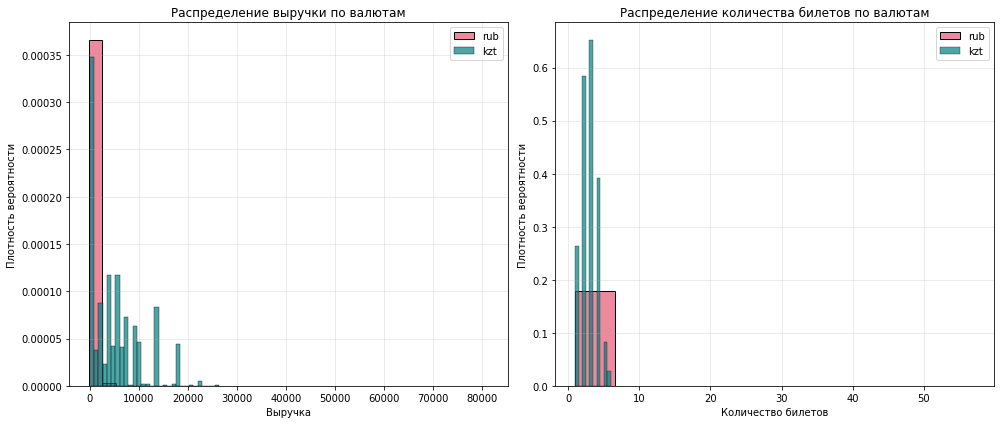

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма для revenue
sns.histplot(data=df[df['currency_code'] == 'rub']['revenue'], bins=30, alpha=0.5, color='crimson', label='rub', stat='density', common_norm=False, ax=ax1)
sns.histplot(data=df[df['currency_code'] == 'kzt']['revenue'], bins=30, alpha=0.7, color='teal', label='kzt', stat='density', common_norm=False, ax=ax1)
ax1.set_title('Распределение выручки по валютам')
ax1.set_xlabel('Выручка')
ax1.set_ylabel('Плотность вероятности')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Гистограмма для tickets_count
sns.histplot(data=df[df['currency_code'] == 'rub']['tickets_count'], bins=10, alpha=0.5, color='crimson', label='rub', stat='density', common_norm=False, ax=ax2)
sns.histplot(data=df[df['currency_code'] == 'kzt']['tickets_count'], bins=10, alpha=0.7, color='teal', label='kzt', stat='density', common_norm=False, ax=ax2)
ax2.set_title('Распределение количества билетов по валютам')
ax2.set_xlabel('Количество билетов')
ax2.set_ylabel('Плотность вероятности')
ax2.grid(True, alpha=0.3)
ax2.legend()


plt.tight_layout()
plt.show()

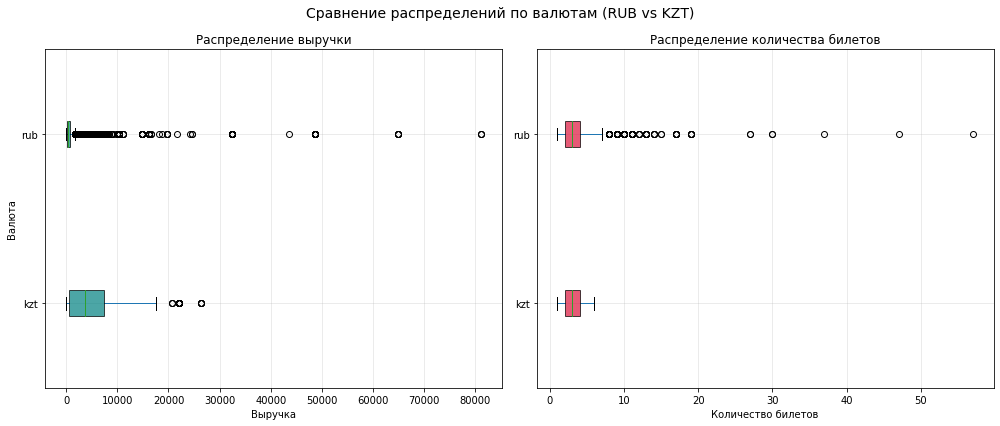

In [16]:
# Фильтруем данные
df_filtered = df[df['currency_code'].isin(['rub', 'kzt'])]

# Создаём фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot для revenue
df_filtered.boxplot(
    column='revenue',
    by='currency_code',
    ax=ax1,
    vert=False,
    grid=True,
    patch_artist=True,  # Позволяет заливать цветом
    boxprops=dict(facecolor='teal', alpha=0.7))

ax1.set_title('Распределение выручки')
ax1.set_xlabel('Выручка')
ax1.set_ylabel('Валюта')
ax1.grid(True, alpha=0.3)

# Boxplot для tickets_count
df_filtered.boxplot(
    column='tickets_count',
    by='currency_code',
    ax=ax2,
    vert=False,
    grid=True,
    patch_artist=True,
    boxprops=dict(facecolor='crimson', alpha=0.7))

ax2.set_title('Распределение количества билетов')
ax2.set_xlabel('Количество билетов')
ax2.set_ylabel('')  # Убираем повторную подпись оси Y
ax2.grid(True, alpha=0.3)


# Общие настройки
plt.suptitle('Сравнение распределений по валютам (RUB vs KZT)', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

Как видно по графикам по revenue есть значительные выбросы, нужно ограничить данные по 99-му процентилю для более корретного анализа.

In [17]:
#Вычисляем 99%
rub_99 = df[df['currency_code'] == 'rub']['revenue'].quantile(0.99)
kzt_99 = df[df['currency_code'] == 'kzt']['revenue'].quantile(0.99)

# Фильтруем данные по условиям
df_rub_filtered = df[(df['currency_code'] == 'rub') & (df['revenue'] <= rub_99)]
df_kzt_filtered = df[(df['currency_code'] == 'kzt') & (df['revenue'] <= kzt_99)]


# Объединяем отфильтрованные датафреймы
df_99 = pd.concat([df_rub_filtered, df_kzt_filtered], ignore_index=True)

# Выводим результат
print(f"Размер исходного датафрейма: {len(df)}")
print(f"Размер итогового датафрейма: {len(df_99)}")
print(f"Размер 99% для рублей: {rub_99:.2f}")
print(f"Размер 99% для тенге: {kzt_99:.2f}")

Размер исходного датафрейма: 290849
Размер итогового датафрейма: 287962
Размер 99% для рублей: 2569.59
Размер 99% для тенге: 17617.24


После отбора данных по 99% для столбца `revenue` у нас было отфильтровано 2887 записей, далее поработаем с получившимся датафреймом и почистим записи по 99% по столбцу `tickets_count` 

In [18]:
# Вычисляем 99%
df_99_tik = df_99['tickets_count'].quantile(0.99)

# Фильтруем исходный датафрейм по условию: tickets_count <= 99-й перцентиль
proces_df = df_99[df_99['tickets_count'] <= df_99_tik]

# Выводим результат
print(f"Размер исходного датафрейма: {len(df_99)}")
print(f"Размер итогового датафрейма: {len(proces_df)}")
print(f"Размер 99%: {df_99_tik:.2f}")

Размер исходного датафрейма: 287962
Размер итогового датафрейма: 287782
Размер 99%: 6.00


После отбора данных по 99% для столбца `tickets_count` у нас было отфильтровано 180 записей, далее приступим к проверке на дубликаты

Работа с выбросами завершена, приступаем к дальнейшей обработке

In [19]:
# Проверяем названия столбцов
proces_df.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address'],
      dtype='object')

In [20]:
# Проверяем на наличие явных дубликатов
check_proces_df = proces_df.duplicated().sum()
print(check_proces_df)

0


In [21]:
# Проверяем на наличие неявних дубликатов в датафрейме
check_df = proces_df.duplicated(subset=['user_id', 'created_dt_msk', 'created_ts_msk',
'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
'event_name', 'event_type_description', 'event_type_main', 'organizers',
'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
'venue_address']).sum()
check_df

30

In [22]:
print(f'Количество строк до предобработки: {len(proces_df)}')

df_clean = proces_df.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
        'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
        'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
        'event_name', 'event_type_description', 'event_type_main', 'organizers',
        'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
        'venue_address'],keep='first')

print(f'Количество строк после предобработки: {len(df_clean)}')
print(f"Удалено дубликатов: {len(proces_df) - len(df_clean)}")

Количество строк до предобработки: 287782
Количество строк после предобработки: 287752
Удалено дубликатов: 30


In [23]:
# Выводим ин-цию по типам данных для убобства дальнейшего форматирования
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287752 entries, 0 to 287961
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                287752 non-null  int64  
 1   user_id                 287752 non-null  object 
 2   created_dt_msk          287752 non-null  object 
 3   created_ts_msk          287752 non-null  object 
 4   event_id                287752 non-null  int64  
 5   cinema_circuit          287752 non-null  object 
 6   age_limit               287752 non-null  int64  
 7   currency_code           287752 non-null  object 
 8   device_type_canonical   287752 non-null  object 
 9   revenue                 287752 non-null  float64
 10  service_name            287752 non-null  object 
 11  tickets_count           287752 non-null  int64  
 12  total                   287752 non-null  float64
 13  days_since_prev         266030 non-null  float64
 14  event_name          

In [24]:
# Создаём копию датафрейма, т.к. пандас начинает сомневаться в наших дальнейших действиях и ругается
df_new = df_clean.copy()  

# Меняем тип данных для оптимизации, а так же приводим дату к верному формату 
df_new['revenue'] = df_new['revenue'].astype('float32')
df_new['total'] = df_new['total'].astype('float32')
df_new['tickets_count'] = df_new['tickets_count'].astype('int16')
df_new['created_dt_msk'] = pd.to_datetime(df_new['created_dt_msk'])
df_new['created_ts_msk'] = pd.to_datetime(df_new['created_ts_msk'])
df_new['city_id'] = df_new['city_id'].astype('int64')
df_new['venue_id'] = df_new['venue_id'].astype('int32')
df_new['age_limit'] = pd.to_numeric(df_new['age_limit'], downcast='integer')
df_new['event_id'] = pd.to_numeric(df_new['event_id'], downcast='unsigned')
df_new['order_id'] = pd.to_numeric(df_new['order_id'], downcast='unsigned')

# Проверяем прошли ли измнения
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287752 entries, 0 to 287961
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  uint32        
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  uint32        
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int16         
 12  total                   287752

Данные для `df_clean` успешно преобразованы, создан новый датафрейм `df_new`

Поработаем так же с датафреймом `final_tickets_tenge_df`, облегчим за счёт форматирования

In [25]:
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [26]:
# Создаём копию
df_tickets_tenge = final_tickets_tenge_df.copy()

# Преобразуем столбец с датой
df_tickets_tenge['data'] = pd.to_datetime(df_tickets_tenge['data'])

# Преобразуем 'nominal' в целое число
df_tickets_tenge['nominal'] = pd.to_numeric(df_tickets_tenge['nominal'],downcast='unsigned',errors='coerce')

# Проверяем изменения
print(df_tickets_tenge.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    uint8         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1), uint8(1)
memory usage: 8.8+ KB
None


In [27]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287752 entries, 0 to 287961
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  uint32        
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  uint32        
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int16         
 12  total                   287752

Данные для `final_tickets_tenge_df` успешно преобразованы, создан новый датафрейм `df_tickets_tenge`

In [28]:
# Облегчим анализ объединив необходимые датафреймы df_new и df_tickets_tenge
df_all = df_new.merge(df_tickets_tenge[['data', 'curs']],left_on='created_dt_msk', right_on='data',how='left')

# Выводим результат
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287752 entries, 0 to 287751
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  uint32        
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  uint32        
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int16         
 12  total                   287752

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648


In [29]:
# Пропишем функцию для конвертации тенге в рубли
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] * (row['curs'] / 100)
    else:
        return row['revenue']
    
# Создадим новый столбец revenue_rub с данными из функции
df_all['revenue_rub'] = df_all.apply(convert_to_rub, axis=1)
df_all.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.939941
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.450012
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.490000
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034


In [30]:
# Создадим новый столбец one_ticket_revenue_rub
df_all['one_ticket_revenue_rub']=df_all['revenue_rub']/df_all['tickets_count']
df_all.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.939941,380.484985
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.450012,144.725006
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946,314.642487
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.490000,4.245000
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034,463.470011


In [31]:
# Создадим новый столбец month
df_all['month']=df_all['created_dt_msk'].dt.month
df_all.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.939941,380.484985,8
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.450012,144.725006,7
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946,314.642487,10
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.490000,4.245000,7
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034,463.470011,10


In [32]:
# Пропишем функцию для определения сезонности
def season_map(month):
    month = int(month)
    if 3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'

df_all['season'] = df_all['month'].map(season_map)
    
# Создадим новый столбец season с данными из функции
df_all.head()


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034,463.470011,10,осень


In [33]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287752 entries, 0 to 287751
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  uint32        
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  uint32        
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int16         
 12  total                   287752

Была произведена `предобработка данных`, что сделано:  
- объединены датафреймы `final_tickets_orders_df` и `final_tickets_events_df`;
- после объединения заменили 818 пропусков на "unknown", сделав данные пригодными для анализа(пропуски остались в столбце `days_since_prev`, т.к. пропуск значит покупки не было);
- поработали с `категориальными значениям`;
- поработали с `количественными значениями` (нашли `выбросы`, отразили графически(гистограмма и Boxplot), почистили по `99%`(было отфильтровано 3067 записей),  
удалили `дубликаты`(датафрейм до предобработки: 287782 строк, после: 287752 строк, удалено: 30 строк), произвели `форматирование по 11 столбцам` (был создан новый датафрейм `df_new`),  
отформатировали так же 2 столбца в датайреме `final_tickets_tenge_df` (был создан новый датафрейм `df_tickets_tenge`), объединили датафреймы `df_new` и `df_tickets_tenge` (были добавлены новые столбцы:  
`revenue_rub` - конвертация тенге в рубли, `one_ticket_revenue_rub` - выручка с продажи одного билета, `month` - месяц оформления заказа, `season` - с категориями: 'лето', 'осень', 'зима', 'весна')

## 3. Исследовательский анализ данных

Проверим динамику объемов заказов по месяцам от июня к ноябрю 2024 года.

In [34]:
# Для каждой группы (каждого месяца) подсчитывает количество непустых значений в order_id
table = df_all.groupby('month')['order_id'].count().reset_index(name='count').sort_values('month')
display(table)

,month,count
0,6,34326
1,7,40381
2,8,44538
3,9,69293
4,10,99214


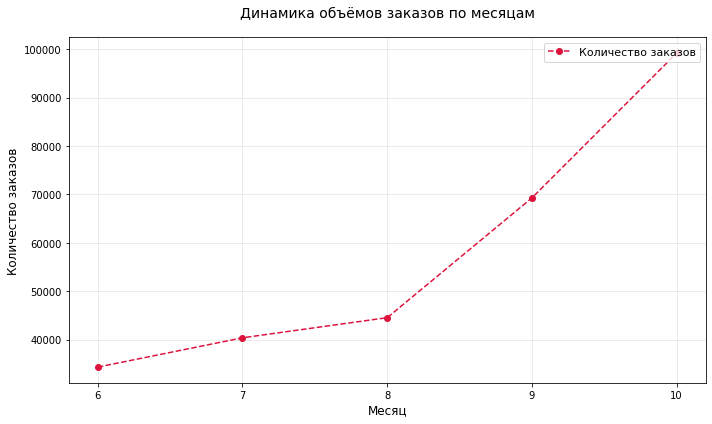

In [35]:
# Создаём контейнер графика
plt.figure(figsize=(10, 6))

# Строим график
plt.plot(table['month'],
    table['count'],
    color='crimson',
    marker='o',
    linestyle='--',
    label='Количество заказов')

# Явно задаём деления оси X — только целые значения из table['month']
plt.xticks(ticks=table['month'], labels=table['month'])

# Настраиваем оси
plt.title('Динамика объёмов заказов по месяцам', fontsize=14, pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)

# Улучшаем компоновку
plt.tight_layout()

# Выводим результат
plt.show()

<Figure size 864x504 with 0 Axes>

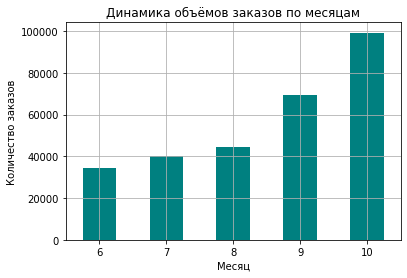

In [36]:
# Создаём дополнительную визуализацию
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 7))

# Строим столбчатую диаграмму
table.plot(kind='bar', # Тип графика — столбчатая диаграмма
        rot=0, # Градус вращения подписи по оси Х
        x='month', 
        color='teal',  
        legend=False,
        title=f'Динамика объёмов заказов по месяцам', 
        width=0.5  # Ширина столбцов
)

# Настраиваем оформление графика
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

# Добавляем сетку графика
plt.grid()


# Выводим график
plt.show()

На основании представленной визуализации можно отметить, что к концу периода проявляется более интенсивная динамика — активность пользователей. Это согласуется с наступлением осени и окончанием летних отпусков.

### Анализ распределения заказов по сегментам и их сезонные изменения

Проанализируем динамику для осеннего и летнего периодов по разрезам:    

- тип мероприятия `event_type_main`;   
- тип устройства `device_type_canonical`;  
- категория мероприятий по возрастному рейтингу `age_limit`.  

In [37]:
# Для удобства выведем уникальные значения мероприятий
df_all['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'unknown', 'ёлки'], dtype=object)

In [38]:
# Создаём 2 отдельных датафрейма для удобства работы
sum_df = df_all[df_all['season'] == 'лето']
autumn_df = df_all[df_all['season'] == 'осень']

# Расчитываем доли меропритий по сезонам 
sum_counts = (sum_df['event_type_main'].value_counts(normalize=True).round(4) * 100)
autumn_counts = (autumn_df['event_type_main'].value_counts(normalize=True).round(4) * 100)

# Объединяем датафреймы
all_counts_event = pd.DataFrame({'Лето': sum_counts, 'Осень': autumn_counts})
all_counts_event

,Лето,Осень
unknown,0.18,0.01
выставки,2.03,1.45
другое,27.09,19.68
концерты,42.56,37.20
спорт,2.52,11.20
стендап,5.32,4.11
театр,20.07,25.36
ёлки,0.23,1.00


<Figure size 720x360 with 0 Axes>

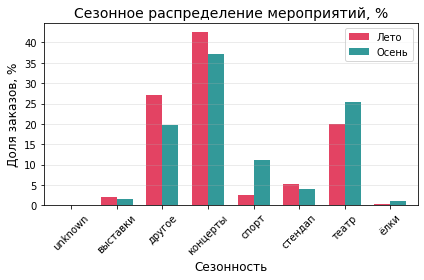

In [39]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
all_counts_event.plot(
    kind='bar',
    rot=45,
    color=['crimson', 'teal'],
    alpha=0.8,
    width=0.7)

# Настраиваем оформление графика
plt.title('Сезонное распределение мероприятий, %', fontsize=14)
plt.xlabel('Сезонность', fontsize=12)
plt.ylabel('Доля заказов, %', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Автоматически подстраиваем отступы
plt.tight_layout()

# Выводим график
plt.show()

Самыми популярными мероприятиями оказались `концерты`, в летний период на их долю приходится `42.56%`, осенью `37.20%`. Затем идут `альтернативные мероприятия`,так же летом популярность выше(`27.09%`) осени(`19.68%`). Почётное третье место принадлежит `театрам`, здесь в осенний период популярность выше(`25.36%`) летнего(`20.07%`).

In [40]:
# Расчитываем доли по типу устройства по сезонам 
sum_device = (sum_df['device_type_canonical'].value_counts(normalize=True).round(4) * 100)
autumn_device = (autumn_df['device_type_canonical'].value_counts(normalize=True).round(4) * 100)

# Объединяем датафреймы
all_counts_device = pd.DataFrame({'Лето': sum_device, 'Осень': autumn_device})
all_counts_device

,Лето,Осень
mobile,80.65,79.67
desktop,19.35,20.33


<Figure size 720x360 with 0 Axes>

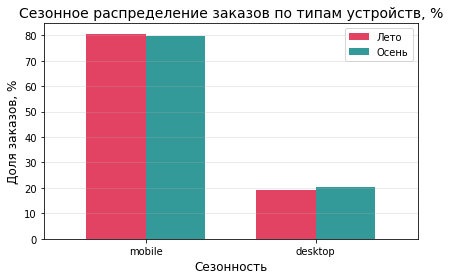

In [41]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
all_counts_device.plot(
    kind='bar',
    rot=0,
    color=['crimson', 'teal'],
    alpha=0.8,
    width=0.7)

# Настраиваем оформление графика
plt.title('Сезонное распределение заказов по типам устройств, %', fontsize=14)
plt.xlabel('Сезонность', fontsize=12)
plt.ylabel('Доля заказов, %', fontsize=12)
plt.grid(axis='y', alpha=0.3)


# Автоматически подстраиваем отступы
plt.tight_layout()

# Выводим график
plt.show()

По `типам устройств` мобильные - самые популярняе по заказам в обоих сезонах (летом - `80.69%`, осеню - `79.67%`).

In [42]:
# Расчитываем доли по возрастному рейтингу по сезонам 
sum_age = (sum_df['age_limit'].value_counts(normalize=True).round(4) * 100)
autumn_age = (autumn_df['age_limit'].value_counts(normalize=True).round(4) * 100)

# Объединяем датафреймы
all_counts_age = pd.DataFrame({'Лето': sum_age, 'Осень': autumn_age})
all_counts_age

,Лето,Осень
0,17.93,23.62
6,18.18,17.63
12,20.56,22.09
16,28.32,26.24
18,15.01,10.42


<Figure size 720x360 with 0 Axes>

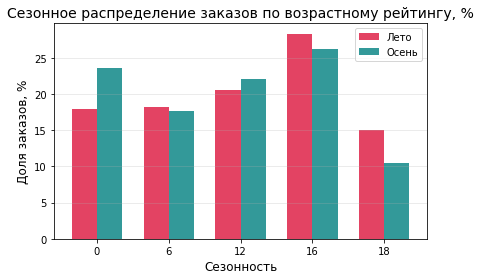

In [43]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
all_counts_age.plot(
    kind='bar',
    rot=0,
    color=['crimson', 'teal'],
    alpha=0.8,
    width=0.7)

# Настраиваем оформление графика
plt.title('Сезонное распределение заказов по возрастному рейтингу, %', fontsize=14)
plt.xlabel('Сезонность', fontsize=12)
plt.ylabel('Доля заказов, %', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Автоматически подстраиваем отступы
plt.tight_layout()

# Выводим график
plt.show()

Как видно по диаграмме, самыми популярными летом были `мероприятиями` `16+(28.32%)`, затем `0+(17.93%)` и `12+(20.56%)`, осенью тендентция сохранялась на 1-м месте `16+(26.24%)`, затем `0+(23.62%)` и `12+(22.09%)`.
Стоит заметить, что с наступление осени % детских мероприятий имеет тенденцию к увеличению. Скорее всего это связано с окончанием каникул и началу сезонна культурно-массовых мроприятий в общеобразовательных учреждениях, а так же со стандартным увеличением количества новинок в осенний период.

### Осенняя активность пользователей
Изучим активность пользователей за сентябрь - октябрь 2024 года.

In [44]:
df_all.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034,463.470011,10,осень


In [45]:
# Формируем сводную таблицу с выручкой
pivot_table = pd.pivot_table(df_all[df_all['season'] == 'осень'],index='created_dt_msk', values=['user_id', 'order_id', 'one_ticket_revenue_rub'],
    aggfunc={'user_id': 'nunique', 'order_id': 'count', 'one_ticket_revenue_rub': 'mean'},fill_value=0).rename(columns={
    'user_id': 'DAU','order_id': 'order_id_count','one_ticket_revenue_rub': 'avg_ticket_rev'})

# Округляем значения ПОСЛЕ создания таблицы
pivot_table['avg_ticket_rev'] = pivot_table['avg_ticket_rev'].round(2)

# Вычисляем среднее количество заказов на пользователя
pivot_table['avg_orders_per_user'] = (pivot_table['order_id_count'] / pivot_table['DAU']).round(2)

# Задаем порядок столбцов
pivot_table = pivot_table[['DAU', 'order_id_count', 'avg_orders_per_user', 'avg_ticket_rev']]

# Выводим результат
pivot_table

,DAU,order_id_count,avg_orders_per_user,avg_ticket_rev
created_dt_msk,,,,
2024-09-01,564,1327,2.35,200.17
2024-09-02,574,1380,2.40,189.46
2024-09-03,778,5111,6.57,80.13
2024-09-04,684,1772,2.59,177.71
2024-09-05,739,1940,2.63,189.76
...,...,...,...,...
2024-10-27,1034,2849,2.76,186.97
2024-10-28,985,2836,2.88,170.60
2024-10-29,998,2834,2.84,177.47


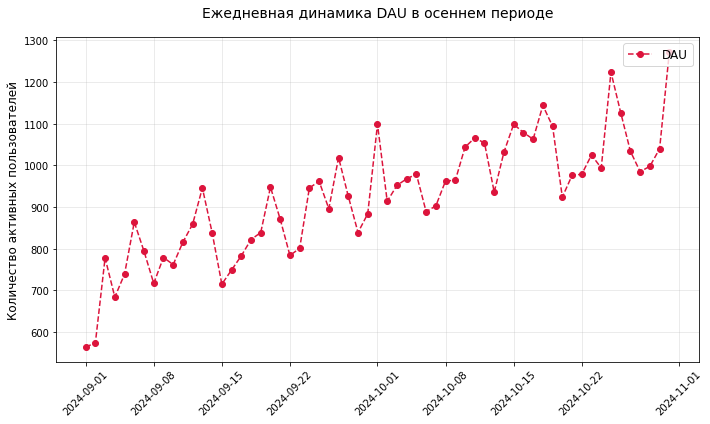

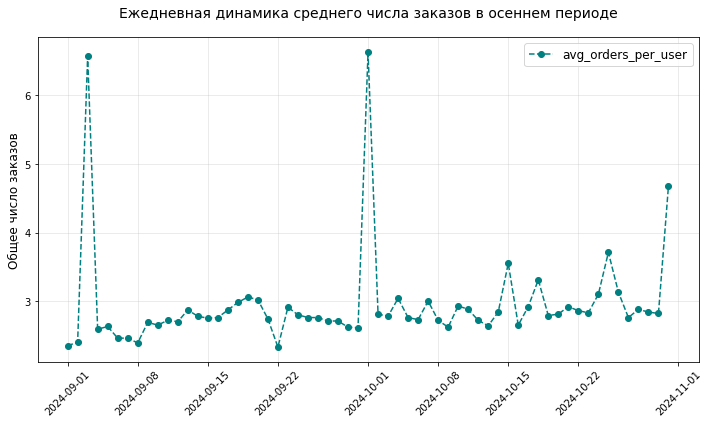

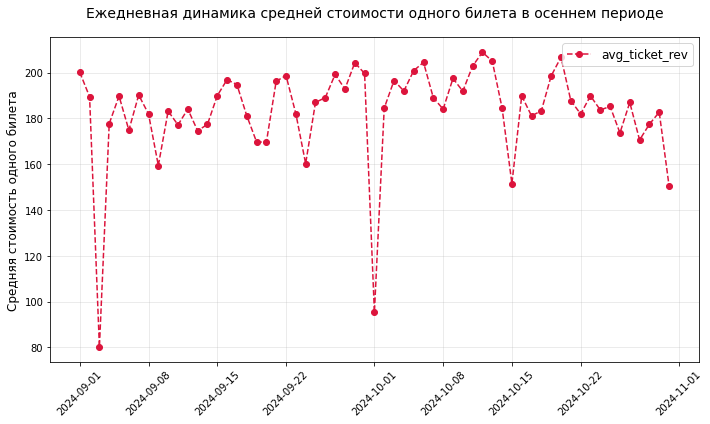

In [46]:
# Создаём график для DAU
# Создаём контейнер графика 
plt.figure(figsize=(10, 6))

# Строим график
plt.plot(pivot_table.index, 
    pivot_table['DAU'], 
    color='crimson',
    marker='o',
    linestyle='--', 
    label='DAU')

# Настраиваем оси
plt.title('Ежедневная динамика DAU в осеннем периоде', fontsize=14, pad=20)
plt.ylabel('Количество активных пользователей', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Выводим результат
plt.show()

# Создаём график для order_id_count
# Создаём контейнер графика 
plt.figure(figsize=(10, 6))

# Строим график
plt.plot(pivot_table.index, 
    pivot_table['avg_orders_per_user'], 
    color='teal',
    marker='o',
    linestyle='--', 
    label='avg_orders_per_user')

# Настраиваем оси
plt.title('Ежедневная динамика среднего числа заказов в осеннем периоде', fontsize=14, pad=20)
plt.ylabel('Общее число заказов', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Выводим результат
plt.show()

# Создаём график avg_orders_per_user
# Создаём контейнер графика 
plt.figure(figsize=(10, 6))

# Строим график
plt.plot(pivot_table.index, 
    pivot_table['avg_ticket_rev'], 
    color='crimson',
    marker='o',
    linestyle='--', 
    label='avg_ticket_rev')

# Настраиваем оси
plt.title('Ежедневная динамика средней стоимости одного билета в осеннем периоде', fontsize=14, pad=20)
plt.ylabel('Средняя стоимость одного билета', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Выводим результат
plt.show()


Как видно по графикам рост количества активных пользователей плавно увеличивался и достиг своего максимума к 01.11.2024г. Заинтересованность клиентов в мероприятиях увеличилась в осенний период.
Поведение среднего показателя по количеству заказов было скачкообразно, можно выделить 3 основные даты с максимальным количеством заказов: 03.09.2024, 01.10.2024, 25.10.2024. Возможо в данные даты применялись маркетинговые акции и дополнительная стимуляция пользователей.  
Так же мы видим скачкообразную динамику по средней стоимости одного билета. Стоимость билетов имела самый низкий показатель 03.09.2024, 01.10.2024. Это даёт нам предворительное подтверждение о эффективной работе маркетинга в указанные даты.

In [47]:
# Добавляем день недели в общий датафрейм для удобства последующей фильтровки
df_all['day_week'] = df_all['created_dt_msk'].dt.day_name()
df_all.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month,season,day_week
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.939941,380.484985,8,лето,Tuesday
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.450012,144.725006,7,лето,Tuesday
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946,314.642487,10,осень,Sunday
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.490000,4.245000,7,лето,Saturday
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034,463.470011,10,осень,Friday


In [48]:
# Создадим датафрейм с данными для недельной статистики
week_stat = df_all[df_all['season'] == 'осень'][['day_week','user_id', 'order_id', 'revenue_rub', 'one_ticket_revenue_rub']]

# Группируем данные
weekly_simple = week_stat.groupby('day_week', as_index=False).agg(
    DAU=('user_id', 'nunique'), 
    total_ord=('order_id', 'count'), 
    total_rev=('revenue_rub', 'sum'), 
    avg_ticket_rev=('one_ticket_revenue_rub', 'mean')).round(2)

# Вычисляем дополнительные метрики
weekly_simple['avg_ord_per_user'] = (weekly_simple['total_ord'] / weekly_simple['DAU']).round(2)
weekly_simple['avg_rev_per_user'] = (weekly_simple['total_rev'] / weekly_simple['DAU']).round(2)

# Определяем правильный порядок дней
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Преобразуем столбец в категориальный тип с заданным порядком
weekly_simple['day_week'] = pd.Categorical(weekly_simple['day_week'], categories=day_order, ordered=True)

# Сортируем по новому порядку
weekly_simple = weekly_simple.sort_values('day_week').reset_index(drop=True)

# Сделаем день недели индексом
weekly_simple = weekly_simple.set_index('day_week')

# Выводим результат
weekly_simple

,DAU,total_ord,total_rev,avg_ticket_rev,avg_ord_per_user,avg_rev_per_user
day_week,,,,,,
Monday,4446,21504,10734567.94,184.12,4.84,2414.43
Tuesday,4793,31468,12141907.77,140.51,6.57,2533.26
Wednesday,4811,22868,11485673.73,185.76,4.75,2387.38
Thursday,4969,27153,12997291.60,177.95,5.46,2615.68
Friday,4869,24804,12577518.43,185.63,5.09,2583.18
Saturday,4569,21327,11264759.87,192.12,4.67,2465.48
Sunday,4392,19383,10480733.59,197.96,4.41,2386.32


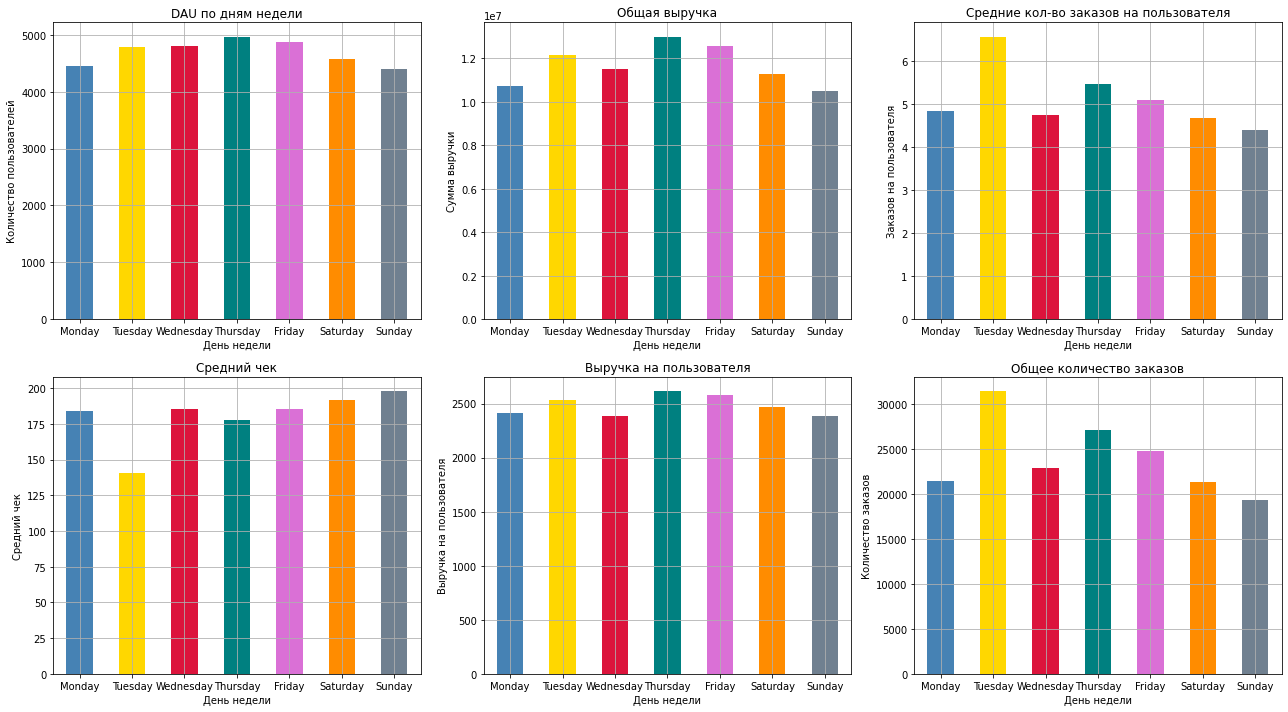

In [49]:
# Создадим обще графическое отражение показателей по дням недели
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
colors = ['steelblue', 'gold', 'crimson', 'teal', 'orchid', 'darkorange', 'slategray']

# График 1: DAU
weekly_simple['DAU'].plot(kind='bar', color=colors, ax=axes[0, 0], rot=0, title='DAU по дням недели')
axes[0, 0].set_xlabel('День недели')
axes[0, 0].set_ylabel('Количество пользователей')
axes[0, 0].grid(True)

# График 2: total_rev
weekly_simple['total_rev'].plot(kind='bar', color=colors, ax=axes[0, 1], rot=0, title='Общая выручка')
axes[0, 1].set_xlabel('День недели')
axes[0, 1].set_ylabel('Сумма выручки')
axes[0, 1].grid(True)

# График 3: avg_ord_per_user
weekly_simple['avg_ord_per_user'].plot(kind='bar', color=colors, ax=axes[0, 2], rot=0, title='Средние кол-во заказов на пользователя')
axes[0, 2].set_xlabel('День недели')
axes[0, 2].set_ylabel('Заказов на пользователя')
axes[0, 2].grid(True)

# График 4: avg_ticket_rev
weekly_simple['avg_ticket_rev'].plot(kind='bar', color=colors, ax=axes[1, 0], rot=0, title='Средний чек')
axes[1, 0].set_xlabel('День недели')
axes[1, 0].set_ylabel('Средний чек')
axes[1, 0].grid(True)

# График 5: avg_rev_per_user
weekly_simple['avg_rev_per_user'].plot(kind='bar', color=colors, ax=axes[1, 1], rot=0, title='Выручка на пользователя')
axes[1, 1].set_xlabel('День недели')
axes[1, 1].set_ylabel('Выручка на пользователя')
axes[1, 1].grid(True)

# График 6: total_ord (добавим для полноты)
weekly_simple['total_ord'].plot(kind='bar', color=colors, ax=axes[1, 2], rot=0, title='Общее количество заказов')
axes[1, 2].set_xlabel('День недели')
axes[1, 2].set_ylabel('Количество заказов')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

По статистике распределения по дням недели можно сделать следующий выводы:  
- наибольшая активность пользователей прослеживается в будние дни(четверг, пятница, среда, вторник);
- общая выручка наиболее высокая так же в будние дни(четверг, пятница, вторник);
- пик по вреднему кол-ву заказов достигнут по вторникам;
- по среднему чеку видно плавное распределение по дням недели, максимальное значение в воскресенье, минимум во вторник;
- распределение выручки на пользователя так же имеет достаточно плавную картину(максимальное значение в четверг);
- по общему кол-ву заказов максимум достигнут во вторник.
С началом осени активность пользователей увеличилась, можно предположить, что люди предпочитают заказывать билеты на мероприятия больше в будние дни, по графику с общим количеством заказов скорее всего прослеживается активная маркетинговая компания, которая спровоцировала столь высокий показатель во вторник.

### Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам:  

- для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. Определим топ-10 регионов с наибольшим разнообразием мероприятий;  
- для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Выявим наиболее активных партнёров.


In [50]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287752 entries, 0 to 287751
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  uint32        
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  uint32        
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int16         
 12  total                   287752

,region_name,unic_event,total_order
24,Каменевский регион,5933,89640
61,Североярская область,3797,43621
78,Широковская область,1232,16164
58,Светополянский округ,1075,7501
53,Речиновская область,702,6266
75,Травяная область,683,5036
12,Горицветская область,551,5153
62,Серебринская область,541,5586
79,Яблоневская область,535,6122
70,Тепляковская область,528,4384


Text(0.5, 1.0, 'Топ‑10 регионов по разнообразию уникальных мероприятий')

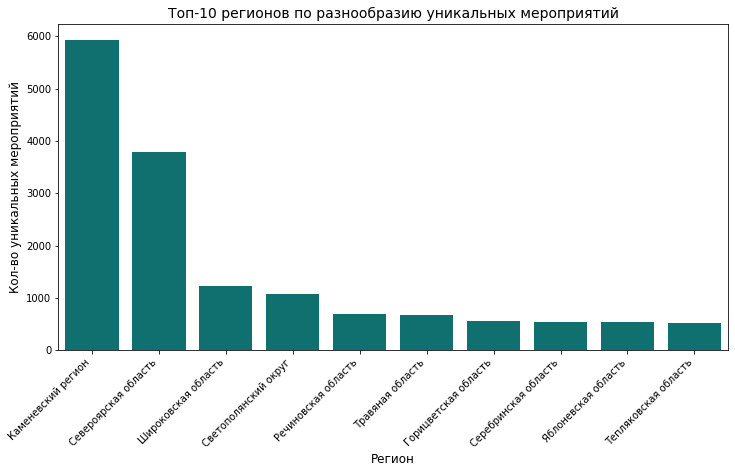

In [51]:
# Создаём датафрейм с группировкой по регионам(топ-10)
region_stat = df_all.groupby('region_name', as_index=False).agg(unic_event=('event_id', 'nunique'), total_order=('order_id', 'count')).sort_values('unic_event', ascending=False).head(10)  

display(region_stat)

# Построим график для удобства визуализации
plt.figure(figsize=(12, 6))

# Строим столбчатую диаграмму с seaborn
ax = sns.barplot(
    data=region_stat,
    x='region_name',
    y='unic_event',
    color='teal',
    order=region_stat['region_name'])

# Добавляем подписи к осям и заголовок
plt.xlabel('Регион', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Кол-во уникальных мероприятий', fontsize=12)
plt.title('Топ‑10 регионов по разнообразию уникальных мероприятий', fontsize=14)

In [52]:
# Вычисляем общее количество уникальных мероприятий и заказов
all_events = region_stat['unic_event'].sum()
all_orders = region_stat['total_order'].sum()

# Добавляем столбец с долей по меропритятиям
region_stat['share_events'] = (region_stat['unic_event'] / all_events * 100).round(2)

# Добавляем столбец с долей по заказам
region_stat['share_orders'] = (region_stat['total_order'] / all_orders * 100).round(2)

print(region_stat)

             region_name  unic_event  total_order  share_events  share_orders
24    Каменевский регион        5933        89640         38.09         47.31
61  Североярская область        3797        43621         24.38         23.02
78   Широковская область        1232        16164          7.91          8.53
58  Светополянский округ        1075         7501          6.90          3.96
53   Речиновская область         702         6266          4.51          3.31
75      Травяная область         683         5036          4.38          2.66
12  Горицветская область         551         5153          3.54          2.72
62  Серебринская область         541         5586          3.47          2.95
79   Яблоневская область         535         6122          3.43          3.23
70  Тепляковская область         528         4384          3.39          2.31


Самый высокий рейтинг по суммарной выручке, разнообразию мероприятий и выручке у `Каменевского региона`- `47.31%` от общего количества заказов и `38.09%` от общего количества мероприятий. На втором месте идёт `Североярская область` - `23.02%` от общего количества заказов и `24.38%`от общего количества мероприятий. Остальные регионы значительно отстают по показателям.
Нужно рассмотреть данные регионы, как потенциально высокие по уровню дохода, провести дополнительные маркетинговые мероприятия для их прокачки. Так же я рекомендую провести дополнительный анализ по отстающим регионам, понять причину столь сильного отставания(возможны недоработки сервиса, технические аспекты, незначительные маркетинговые усилия).

,service_name,unic_event,total_order,total_revenue
21,Лови билет!,4869,40798,16669768.00
3,Билеты без проблем,4249,62889,26301990.00
5,Билеты в руки,3536,40295,13194297.00
25,Облачко,2335,26402,18588614.00
22,Лучшие билеты,1763,17752,2718136.75
24,Мой билет,1299,34418,39365120.00
30,Тебе билет!,1062,5177,2928882.75
26,Прачечная,1026,10222,4746810.50
8,Весь в билетах,855,16410,16494669.00
35,Яблоко,714,5004,3868337.00


Text(0.5, 1.0, 'Топ‑10 операторов по активности продаж')

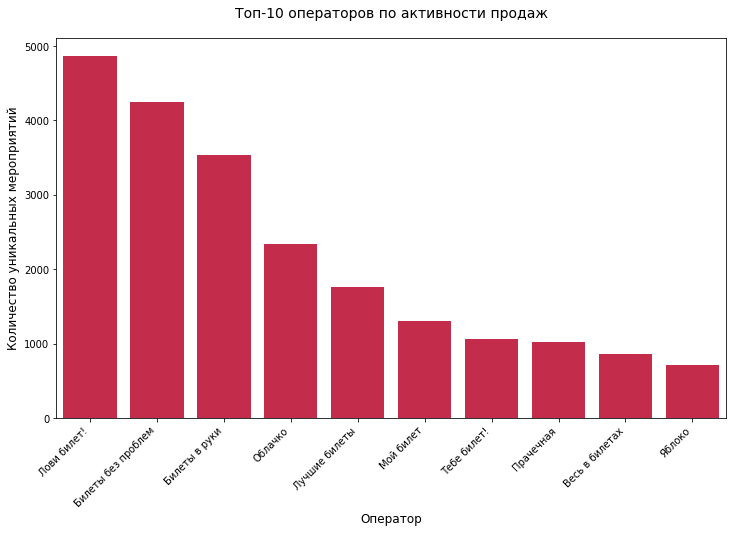

In [53]:
# Создаём датафрейм с группировкой по билетным партнёрам(топ-10)
service_stat = df_all.groupby('service_name', as_index=False).agg(unic_event=('event_id', 'nunique'), total_order=('order_id', 'count'), total_revenue=('revenue', 'sum')).sort_values('unic_event', ascending=False).head(10)  

display(service_stat)

# Построим график для удобства визуализации
plt.figure(figsize=(12, 7))

# Строим столбчатую диаграмму
ax = sns.barplot(
    data=service_stat,
    x='service_name',
    y='unic_event',
    color='crimson',
    order=service_stat['service_name'])

# Добавляем подписи к осям и заголовок
plt.xlabel('Оператор', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Количество уникальных мероприятий', fontsize=12)
plt.title('Топ‑10 операторов по активности продаж', fontsize=14, pad=20)

In [54]:
# Вычисляем общее количество уникальных мероприятий и заказов
all_events2 = service_stat['unic_event'].sum()
all_orders2 = service_stat['total_order'].sum()
all_revenue = service_stat['total_revenue'].sum()

# Добавляем столбец с долей по меропритятиям
service_stat['share_events'] = (service_stat['unic_event'] / all_events2 * 100).round(2)

# Добавляем столбец с долей по заказам
service_stat['share_orders'] = (service_stat['total_order'] / all_orders2 * 100).round(2)

# Добавляем столбец с долей по выручке
service_stat['share_revenue'] = (service_stat['total_revenue'] / all_revenue * 100).round(2)

display(service_stat)

,service_name,unic_event,total_order,total_revenue,share_events,share_orders,share_revenue
21,Лови билет!,4869,40798,16669768.00,22.43,15.73,11.51
3,Билеты без проблем,4249,62889,26301990.00,19.57,24.25,18.15
5,Билеты в руки,3536,40295,13194297.00,16.29,15.54,9.11
25,Облачко,2335,26402,18588614.00,10.76,10.18,12.83
22,Лучшие билеты,1763,17752,2718136.75,8.12,6.84,1.88
24,Мой билет,1299,34418,39365120.00,5.98,13.27,27.17
30,Тебе билет!,1062,5177,2928882.75,4.89,2.00,2.02
26,Прачечная,1026,10222,4746810.50,4.73,3.94,3.28
8,Весь в билетах,855,16410,16494669.00,3.94,6.33,11.39
35,Яблоко,714,5004,3868337.00,3.29,1.93,2.67


По результатам исследования билетных операторов лидирующие позиции по количеству проведенных мероприятий занимают: `Лови билет!(22.43%)`, `Билеты без проблем(19.57%)` и `Билеты в руки(16.29%)`.
Однако по суммарной выручке лидером является `Мой билет(27.17%)`, затем `Билеты без проблем(18.15%)` и `Облачко(12.83%)`. По количеству заказов лидер - `Билеты без проблем(24.25%)`, затем `Лови билет!(15.73%)` и `Билеты в руки(15.54%)`.
Разрыв между лидерами и остальными операторами по некоторым показателям достаточно большой, рекомендую обратить на это внимание и провести дополнительный анализ на выявление причин столь сильного отставания.

## 4. Статистический анализ данных

Коллеги из продуктового отдела хотят отдельно проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств. 
Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств;
- среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Исследование нужно провести по данные только за осенний период.

### 1-ая гипотеза

In [55]:
# Создадим датафрейм с информацией только по осенним данным
df = df_all[df_all['season'] == 'осень']
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month,season,day_week
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.569946,314.642487,10,осень,Sunday
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.410034,463.470011,10,осень,Friday
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.739990,...,930,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",2024-10-23,20.0531,902.739990,300.913330,10,осень,Wednesday
7,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.779999,...,3159,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",2024-09-29,19.3741,47.779999,47.779999,9,осень,Sunday
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.839996,...,3159,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",2024-10-15,19.7185,74.839996,37.419998,10,осень,Tuesday


In [56]:
df_mob = df[df['device_type_canonical'] == 'mobile']['user_id']
df_desc = df[df['device_type_canonical'] == 'desktop']['user_id']

# Получаем уникальные user_id
mob_unique = set(df_mob.unique())      
desc_unique = set(df_desc.unique())  

# Находим пересечение
intersection_df = mob_unique & desc_unique

# Выводим результаты
print(f"Размер группы mobile: {len(mob_unique)}")
print(f"Размер группы desktop: {len(desc_unique)}")
print(f"Найдено пересечений: {len(intersection_df)}")

Размер группы mobile: 14185
Размер группы desktop: 4867
Найдено пересечений: 3249


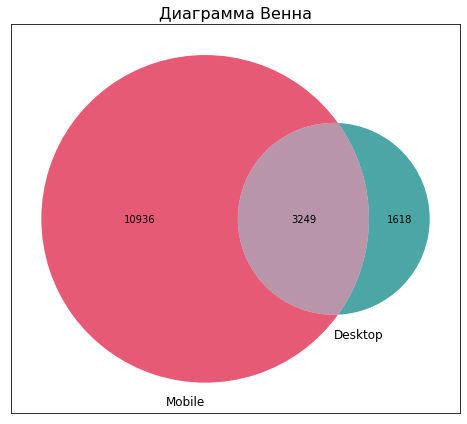

In [57]:
# Создаем диаграмму Венна
plt.figure(figsize=(8, 6))  # Устанавливаем размер фигуры
venn_diagram = venn2(
    [mob_unique, desc_unique],  
    set_labels=('Mobile', 'Desktop'),  # Подписываем множества
    set_colors=('crimson','teal'),  # Задаем цвета
    alpha=0.7)

# Настраиваем внешний вид
plt.title('Диаграмма Венна', fontsize=16)
plt.axis('on')  # Показываем оси
plt.tight_layout()  # Автоматически настраиваем отступы

plt.show()

In [58]:
# Уберём перечечения
df_mob = df_mob[~df_mob.isin(intersection_df)]
df_desc = df_desc[~df_desc.isin(intersection_df)]

# Проверяем пересечения после чистки
mob_unique = set(df_mob.unique()) 
desc_unique = set(df_desc.unique())
intersection = mob_unique & desc_unique

# Выводим результаты
print(f"Размер группы mobile: {len(mob_unique)}")
print(f"Размер группы desktop: {len(desc_unique)}")
print(f"Найдено пересечений: {len(intersection)}")

Размер группы mobile: 10936
Размер группы desktop: 1618
Найдено пересечений: 0


По результатам проверки мы видим, что группа с мобильными устройствами(10936) значительно больше гуппы с компьютерами(1618), так же были устранены пересечения(3249). 

In [59]:
# Получаем исходные данные для групп
group_A_data = (df[df['user_id'].isin(df_mob)].groupby('user_id')['order_id'].count())
group_B_data = (df[df['user_id'].isin(df_desc)].groupby('user_id')['order_id'].count())
                                                                            
# Вычисляем статистику                                                                                                                                                 
group_A_stats = group_A_data.describe(percentiles=[0.5, 0.95, 0.99])
group_B_stats = group_B_data.describe(percentiles=[0.5, 0.95, 0.99])

# Выводим статистику
print(f"Группа A - Статистика по order_id:\n{group_A_stats.round(2)}")
print(f"\nГруппа B - Статистика по order_id:\n{group_B_stats.round(2)}")

Группа A - Статистика по order_id:
count    10936.00
mean         2.86
std          4.10
min          1.00
50%          2.00
95%          9.00
99%         20.00
max        123.00
Name: order_id, dtype: float64

Группа B - Статистика по order_id:
count    1618.00
mean        1.97
std         3.06
min         1.00
50%         1.00
95%         5.00
99%        12.00
max        56.00
Name: order_id, dtype: float64


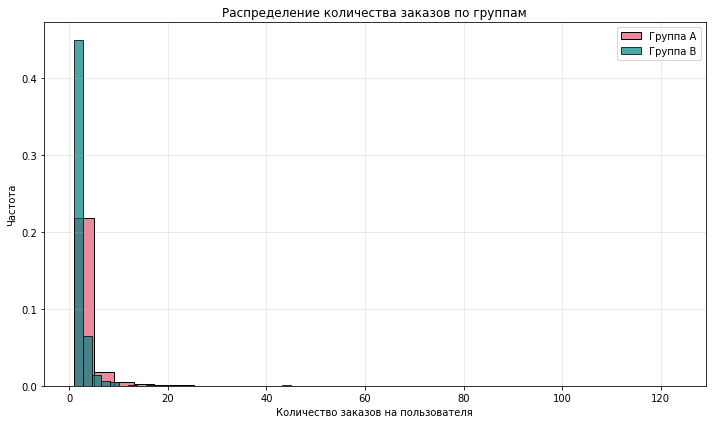

In [60]:
plt.figure(figsize=(10, 6))

# Создаём оси (ax) для построения графиков
ax = plt.gca()

# Строим гистограммы на одних осях
sns.histplot(group_A_data, bins=30, alpha=0.5, color='crimson', label='Группа A', stat='density', common_norm=False, ax=ax)
sns.histplot(group_B_data, bins=30, alpha=0.7, color='teal', label='Группа B', stat='density', common_norm=False, ax=ax)
ax.set_title('Распределение количества заказов по группам')
ax.set_xlabel('Количество заказов на пользователя')
ax.set_ylabel('Частота')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

По статистическим данным можно сделать выводы:  
- группа A в 6.7 раз больше по размеру выборки;  
- сильное разброс между min и max значения в обоих группах;  
- в 50% случав в группе А было сделано 2 заказа, в группе В 1 (среднее > медианы), это доказывает правосторонний хвост;   
- среднее значение в группе A(2,86) на 45 % выше, чем в B (1,97).

В данной ситуации уместно использовать U‑тест Манна‑Уитни (так как есть сильные выбросы/асимметрия).

`Формулировка гипотезы`:  
    
`Нулевая гипотеза (H0)`: среднее количество заказов с мобильного приложения не отличается от среднего количества со стационарных устройств;   

`Альтернативная гипотеза (H1)`: среднее количество заказов с мобильного приложения выше, чем со стационарных устройств 

In [61]:
alpha = 0.05

# Вычисляем p-value
mw_pvalue = mannwhitneyu(group_A_data, group_B_data, alternative='greater').pvalue

# Выводим результата с форматированием
print(f'mw_pvalue = {mw_pvalue:.4f}')

# Провяем гипотезы
if mw_pvalue > alpha:
    print(f'p-value = {mw_pvalue:.4f}, нулевая гипотеза не отвергается')
else:
    print(f'p-value = {mw_pvalue:.4f}, принимаем альтернативную гипотезу')

mw_pvalue = 0.0000
p-value = 0.0000, принимаем альтернативную гипотезу


По результата теста можно сделать вывод, что пользователи группы А(мобильные устройства) активнее пользователей группы В, т.е. среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

### 2-ая гипотеза

In [62]:
# Получаем средние по пользователям для групп без Nan
group_A = df[(df['user_id'].isin(df_mob)) & (df['days_since_prev'].notna())]
group_B = df[(df['user_id'].isin(df_desc)) & (df['days_since_prev'].notna())]
    
print(f"Группа A: {len(group_A)} записей")
print(group_A['days_since_prev'].describe().round(2))
    
print(f"\nГруппа B: {len(group_B)} записей")
print(group_B['days_since_prev'].describe().round(2))

Группа A: 24587 записей
count    24587.00
mean        13.78
std         25.70
min          0.00
25%          0.00
50%          1.00
75%         15.00
max        148.00
Name: days_since_prev, dtype: float64

Группа B: 2077 записей
count    2077.00
mean       18.07
std        32.68
min         0.00
25%         0.00
50%         0.00
75%        22.00
max       146.00
Name: days_since_prev, dtype: float64


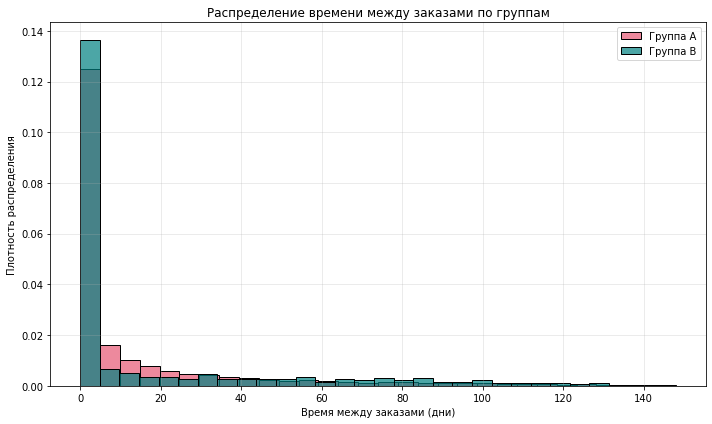

In [63]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Строим гистограммы по исходным данным (а не по count!)
sns.histplot(group_A['days_since_prev'],bins=30,alpha=0.5,color='crimson',label='Группа A',stat='density',common_norm=False,ax=ax)
sns.histplot(group_B['days_since_prev'],bins=30,alpha=0.7,color='teal',label='Группа B',stat='density',common_norm=False,ax=ax)

ax.set_title('Распределение времени между заказами по группам')
ax.set_xlabel('Время между заказами (дни)')
ax.set_ylabel('Плотность распределения')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

По статистическим данным можно сделать выводы:  
- группа A в 11.83 раза больше по размеру выборки;  
- сильное разброс между min и max значения в обоих группах;    
- у группы B события происходят в один и тот же день (или почти подряд), в группе A половина интервалов — не менее 1 дня; 
- в группе B в среднем больше времени проходит между событиями;
- в группе B межквартильный размах больше, значит шире диапазон «типичных» значений;
- средние значения в обоих группах значительно больше медианы, что говорит о значительных выбросах.

В данной ситуации уместно использовать U‑тест Манна‑Уитни (так как есть сильные выбросы/асимметрия).

Формулировка гипотезы:  
    
`Нулевая гипотеза (H0)`: среднее время между заказами мобильных приложений не отличается от среднего времени со стационарных устройств;   

`Альтернативная гипотеза (H1)`: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [64]:
alpha = 0.05

# Вычисляем p-value
mw_pvalue = mannwhitneyu(group_A['days_since_prev'], group_B['days_since_prev'], alternative='greater').pvalue

# Выводим результата с форматированием
print(f'mw_pvalue = {mw_pvalue:.4f}')

# Провяем гипотезы
if mw_pvalue > alpha:
    print(f'p-value = {mw_pvalue:.4f}, нулевая гипотеза не отвергается')
else:
    print(f'p-value = {mw_pvalue:.4f}, принимаем альтернативную гипотезу')

mw_pvalue = 0.0000
p-value = 0.0000, принимаем альтернативную гипотезу


По результата теста принимаем альтернативную гипотезу: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

###  5. Общий вывод и рекомендации

### Итоговый вывод

По запросу продуктовой команды был произведён исследовательский анализ данных о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.  

Работа была произведена по 2 датсетам `final_tickets_orders_df.csv, final_tickets_events_df.csv и final_tickets_tenge_df.csv`. Данные были проверены на корректность форматов, наличие дубликатов и пропусков.
В результате:
- объединены датафреймы final_tickets_orders_df и final_tickets_events_df;
- после объединения заменили 818 пропусков на "unknown", сделав данные пригодными для анализа(пропуски остались в столбце days_since_prev, т.к. пропуск значит покупки не было);
- поработали с категориальными значениям;
- поработали с количественными значениями (нашли выбросы, отразили графически(гистограмма и Boxplot), почистили по 99%(было отфильтровано 3067 записей),
- удалили дубликаты(датафрейм до предобработки: 287782 строк, после: 287752 строк, удалено: 30 строк), произвели форматирование по 11 столбцам (был создан новый датафрейм df_new),
- отформатировали так же 2 столбца в датайреме final_tickets_tenge_df (был создан новый датафрейм df_tickets_tenge), объединили датафреймы df_new и df_tickets_tenge (были добавлены новые столбцы:
- revenue_rub - конвертация тенге в рубли, one_ticket_revenue_rub - выручка с продажи одного билета, month - месяц оформления заказа, season - с категориями: 'лето', 'осень', 'зима', 'весна').
Количественные данные были урезаны по 99% из-за большого разброса, предположительно выбросы.

Был произведён `исследовательский анализ` данных динамики объемов заказов по месяцам от июня к ноябрю 2024 года, который показал, что к концу периода проявляется более интенсивная динамика активности пользователей. Это согласуется с наступлением осени и окончанием летних отпусков.

Отдельно произведен `анализ распределения` заказов по сегментам и их сезонные изменения для осеннего и летнего периодов по разрезам:
- тип мероприятия event_type_main;
- тип устройства device_type_canonical;
- категория мероприятий по возрастному рейтингу age_limit. 

Самыми популярными мероприятиями оказались концерты, в летний период на их долю приходится 42.56%, осенью 37.20%. Затем идут альтернативные мероприятия,так же летом популярность выше(27.09%) осени(19.68%). Почётное третье место принадлежит театрам, здесь в осенний период популярность выше(25.36%) летнего(20.07%). 

По типам устройств мобильные самые популярные по заказам в обоих сезонах (летом - 80.69%, осеню - 79.67%).
Самыми популярными летними мероприятиями по возрастному ограничению оказались 16+(28.32%), затем 0+(17.93%) и 12+(20.56%), осенью тенденция сохранялась на 1-м месте 16+(26.24%), затем 0+(23.62%) и 12+(22.09%). Стоит заметить, что с наступление осени % детских мероприятий имеет тенденцию к увеличению.Скорее всего это связано с окончанием каникул и началу сезонна культурно-массовых мероприятий в общеобразовательных учреждениях, а так же со стандартным увеличением количества новинок в осенний период.                                          
                                       
Отдельно была изучена `активность пользователей за сентябрь - октябрь 2024 года`.

Рост количества активных пользователей плавно увеличивался и достиг своего максимума к 01.11.2024г. Заинтересованность клиентов в мероприятиях увеличилась в осенний период. Поведение среднего показателя по количеству заказов было скачкообразно, можно выделить 3 основные даты с максимальным количеством заказов: 03.09.2024, 01.10.2024, 25.10.2024. Возможо в данные даты применялись маркетинговые акции и дополнительная стимуляция пользователей.
Так же мы видим скачкообразную динамику по средней стоимости одного билета. Стоимость билетов имела самый низкий показатель 03.09.2024, 01.10.2024. Это даёт нам предварительное подтверждение о эффективной работе маркетинга в указанные даты.                                          
Статистика распределения по дням недели показала, что наибольшая активность пользователей прослеживается в будние дни(четверг, пятница, среда, вторник), общая выручка наиболее высокая так же в будние дни(четверг, пятница, вторник), пик по среднему кол-ву заказов достигнут по вторникам, по среднему чеку прослеживается плавное распределение по дням недели, максимальное значение в воскресенье, минимум во вторник, распределение выручки на пользователя так же имеет достаточно плавную картину(максимальное значение в четверг), по общему кол-ву заказов максимум достигнут во вторник. С началом осени активность пользователей увеличилась, можно предположить, что люди предпочитают заказывать билеты на мероприятия больше в будние дни, по графику с общим количеством заказов скорее всего прослеживается активная маркетинговая компания, которая спровоцировала столь высокий показатель во вторник.                                         

Изучено `распределение событий по регионам и партнёрам`.

Самый высокий рейтинг по суммарной выручке, разнообразию мероприятий у Каменевского региона- 47.31% от общего количества заказов и 38.09% от общего количества мероприятий. На втором месте идёт Североярская область - 23.02% от общего количества заказов и 24.38% от общего количества мероприятий. Остальные регионы значительно отстают по показателям. Нужно рассмотреть данные регионы, как потенциально высокие по уровню дохода, провести дополнительные маркетинговые мероприятия для их прокачки. Так же я рекомендую провести дополнительный анализ по отстающим регионам, понять причину столь сильного отставания(возможны недоработки сервиса, технические аспекты, незначительные маркетинговые усилия).                                       
По результатам исследования билетных операторов лидирующие позиции по количеству проведенных мероприятий занимают: Лови билет!(22.43%), Билеты без проблем(19.57%) и Билеты в руки(16.29%). Однако по суммарной выручке лидером является Мой билет(27.17%), затем Билеты без проблем(18.15%) и Облачко(12.83%). По количеству заказов лидер - Билеты без проблем(24.25%), затем Лови билет!(15.73%) и Билеты в руки(15.54%). Разрыв между лидерами и остальными операторами по некоторым показателям достаточно большой, рекомендую обратить на это внимание и провести дополнительный анализ на выявление причин столь сильного отставания.                                                                          
Произведён `статистический анализ данных`.

Исследование проводилось по данные за осенний период и было проверено 2 гипотезы относительно активности пользователей мобильных и стационарных устройств:  
- среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств;  
- среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.  

Так как при статистическом анализе групп оказалось, что группы в обоих случаях не равномерны по ко-ву и имеют значительные перекосы по данным (выбросы, разная активность, большая разница между статистически значимыми показателями) был применен U‑тест Манна‑Уитни (использован alpha = 0.05).  
По результатам тестирования мы получили вывод, что пользователи группы А(мобильные устройства) активнее пользователей группы В, т.е. среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств для первой гипотезы и среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств для второй.   
То есть люди более активно используют мобильные устройства для ознакомления и оформления заказов. Это связано с удобством при перемещении и независимостью от конкретного места(в отличии от пс). Данный факт необходимо учитывать при разработке маркетинговых акций, а так же прокачке мобильных приложений.

### Рекомендации

При работе мы увидели значительное количество недостающей информации. Возможно это связано с техническими аспектами или мануальными недоработками. Рекомендую дополнительно проверить этот момент, если есть несовместимость приложений при заливке данных в одну систему, то следует произвести доработку, т.к. значительный % данных утрачивается и это может сильно повлиять на общую картину для данного бизнес раздела. Так же проверить все этапы формирования заказа.  
По регионам есть значительный перекос в плане разнообразия мероприятий(стоит проанализировать кол-во мероприятий, их разнообразность, ценовую политику), данный факт обязательно учитывать для прокачки уже раскрученного региона, а так же произвести дополнительный анализ и направить внимание маркетингового отдела для прокачки потенциальных регионов(в приоритете Североярская область, провести исследование предпочтений аудитории, возможно привлечение партнёров).  
Усилить осеннюю маркетинговую стратегию, так как большая популярность мероприятий зафиксировано именно в этот период.
Разобраться, что входит в категорию - 'другие' по мероприятиям, так же простимулировать концерты и театры, как потенциально приносящие прибыль. Обратить внимание на спортивные мероприятия, вытавки, стендапы, по ним показатели сильно ниже, требуется исследование и дополнительная стимуляция(промо-компании, усиление рекламы, партнерские скидки и тд.).
Рассмотреть усиление маркетингового подхода к мероприятиям 18+ в летний сезон.  
Произвести дополнительное исследование билетных партнеров для определения причины столько низких показателей.   
Стоит так же простимулировать прокачивание мобильных приложений, как потенциально прибыльных.  
Проработать популярность Яндекс Афиши как бренда, это может простимулировать частоту и объём заказов, просмотренность.  